In [1]:
import math, os
from time import time

import torch
from spaVAE_Batch import SPAVAE
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import h5py
import scanpy as sc
from preprocess import normalize

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
'''
Parameter setting
'''

class Args(object):
    def __init__(self):
        self.data_file = 'anterior_section1.h5_anterior_section2.h5_union_ant.h5'
        self.select_genes = 0
        self.batch_size = 512
        self.maxiter = 2000
        self.lr = 1e-3
        self.weight_decay = 1e-2
        self.noise = 0
        self.dropoutE = 0
        self.dropoutD = 0
        self.encoder_layers = [128, 64, 32]
        self.z_dim = 2
        self.decoder_layers = [32]
        self.beta = 20
        self.num_samples = 1
        self.shared_dispersion = False
        self.fix_inducing_points = True
        self.inducing_point_nums = None
        self.fixed_gp_params = False
        self.loc_range = 20.
        self.kernel_scale = 20.
        self.allow_batch_kernel_scale = True
        self.model_file = "model.pt"
        self.final_latent_file = "final_latent.txt"
        self.device = "cpu"

args = Args()

print(args)

In [3]:
data_mat = h5py.File(args.data_file, 'r')
x = np.array(data_mat['X']).astype('float64')
loc = np.array(data_mat['pos']).astype('float64')
batch = np.array(data_mat['batch']).astype('float64')
data_mat.close()

n_batch = batch.shape[1]

loc_scaled = np.zeros(loc.shape, dtype=np.float64)
for i in range(n_batch):
    scaler = MinMaxScaler()
    b_loc = loc[batch[:,i]==1, :]
    b_loc = scaler.fit_transform(b_loc) * 20.
    loc_scaled[batch[:,i]==1, :] = b_loc
loc = loc_scaled

loc = np.concatenate((loc, batch), axis=1)

np.savetxt("scaled_loc.txt", loc, delimiter=",")


print("count matrix", x.shape)
print("location matrix", loc.shape)
print("batch matrix", batch.shape)

# build inducing point matrix with batch index
# set inducing points for anterior and posterior respectively. 81 for anteriors, 256 for posteriors.
eps = 1e-4
initial_inducing_points_0 = []
initial_inducing_points_shape = []
for i in range(n_batch):
    n_steps = 8
    initial_inducing_points_0_ = np.mgrid[0:(1+eps):(1./n_steps), 0:(1+eps):(1./n_steps)].reshape(2, -1).T * args.loc_range
    initial_inducing_points_0.append(initial_inducing_points_0_)
    initial_inducing_points_shape.append(initial_inducing_points_0_.shape[0])
initial_inducing_points_0 = np.concatenate(initial_inducing_points_0, axis=0)
# print(initial_inducing_points_shape)
initial_inducing_points_1 = []
for i in range(n_batch):
    initial_inducing_points_1_ = np.zeros((initial_inducing_points_shape[i], n_batch))
    initial_inducing_points_1_[:, i] = 1
    initial_inducing_points_1.append(initial_inducing_points_1_)
initial_inducing_points_1 = np.concatenate(initial_inducing_points_1, axis=0)
initial_inducing_points = np.concatenate((initial_inducing_points_0, initial_inducing_points_1), axis=1)
print("inducing point shape", initial_inducing_points.shape)

np.savetxt("initial_inducing_points.txt", initial_inducing_points, delimiter=",")

adata = sc.AnnData(x, dtype="float64")

adata = normalize(adata,
                  size_factors=True,
                  normalize_input=True,
                  logtrans_input=True)

model = SPAVAE(input_dim=adata.n_vars, z_dim=args.z_dim, n_batch=n_batch, encoder_layers=args.encoder_layers, decoder_layers=args.decoder_layers,
    noise=args.noise, encoder_dropout=args.dropoutE, decoder_dropout=args.dropoutD, shared_dispersion=args.shared_dispersion,
    fixed_inducing_points=args.fix_inducing_points, initial_inducing_points=initial_inducing_points, 
    fixed_gp_params=args.fixed_gp_params, kernel_scale=args.kernel_scale, allow_batch_kernel_scale=args.allow_batch_kernel_scale,
    N_train=adata.n_obs, beta=args.beta, dtype=torch.float64, device=args.device)

print(str(model))

count matrix (5520, 2491)
location matrix (5520, 4)
batch matrix (5520, 2)
inducing point shape (162, 4)
SPAVAE(
  (svgp): SVGP(
    (kernel): BatchedCauchyKernel()
    (sample_kernel): SampleKernel()
  )
  (encoder): DenseEncoder(
    (layers): Sequential(
      (0): Linear(in_features=2493, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ELU(alpha=1.0)
      (3): Linear(in_features=128, out_features=64, bias=True)
      (4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ELU(alpha=1.0)
      (6): Linear(in_features=64, out_features=32, bias=True)
      (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ELU(alpha=1.0)
    )
    (enc_mu): Linear(in_features=32, out_features=2, bias=True)
    (enc_var): Linear(in_features=32, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=4, out_f

In [4]:
t0 = time()

model.train_model(pos=loc, ncounts=adata.X, raw_counts=adata.raw.X, size_factors=adata.obs.size_factors, batch=batch,
            lr=args.lr, weight_decay=args.weight_decay, batch_size=args.batch_size, num_samples=args.num_samples,
            maxiter=args.maxiter, save_model=True, model_weights=args.model_file)
print('Training time: %d seconds.' % int(time() - t0))

final_latent = model.batching_latent_samples(X=loc, Y=adata.X, B=batch, batch_size=args.batch_size)
np.savetxt(args.final_latent_file, final_latent, delimiter=",")

Training
Training epoch 1, ELBO:48.48620486, NB loss:2.42287669, KLD loss:0.02867112, noise regularization:0.000000
Current kernel scale tensor([20.0069, 19.9998])
Training epoch 2, ELBO:46.84067283, NB loss:2.34033084, KLD loss:0.03405610, noise regularization:0.000000
Current kernel scale tensor([20.0154, 20.0078])
Training epoch 3, ELBO:45.55808381, NB loss:2.27578783, KLD loss:0.04232720, noise regularization:0.000000
Current kernel scale tensor([20.0242, 20.0169])
Training epoch 4, ELBO:44.26988526, NB loss:2.21125445, KLD loss:0.04479635, noise regularization:0.000000
Current kernel scale tensor([20.0330, 20.0268])
Training epoch 5, ELBO:43.20336887, NB loss:2.15772938, KLD loss:0.04878132, noise regularization:0.000000
Current kernel scale tensor([20.0417, 20.0359])
Training epoch 6, ELBO:42.15986587, NB loss:2.10534920, KLD loss:0.05288178, noise regularization:0.000000
Current kernel scale tensor([20.0502, 20.0451])
Training epoch 7, ELBO:41.12836053, NB loss:2.05361661, KLD l

Training epoch 54, ELBO:30.25182860, NB loss:1.51081930, KLD loss:0.03544260, noise regularization:0.000000
Current kernel scale tensor([20.2724, 20.3449])
Training epoch 55, ELBO:30.25225570, NB loss:1.51080269, KLD loss:0.03620194, noise regularization:0.000000
Current kernel scale tensor([20.2753, 20.3498])
Training epoch 56, ELBO:30.24337294, NB loss:1.51038617, KLD loss:0.03564953, noise regularization:0.000000
Current kernel scale tensor([20.2782, 20.3546])
Training epoch 57, ELBO:30.20006549, NB loss:1.50820002, KLD loss:0.03606505, noise regularization:0.000000
Current kernel scale tensor([20.2809, 20.3594])
Training epoch 58, ELBO:30.12982392, NB loss:1.50468780, KLD loss:0.03606801, noise regularization:0.000000
Current kernel scale tensor([20.2836, 20.3642])
Training epoch 59, ELBO:30.13753097, NB loss:1.50509331, KLD loss:0.03566477, noise regularization:0.000000
Current kernel scale tensor([20.2864, 20.3691])
Training epoch 60, ELBO:30.13790521, NB loss:1.50512067, KLD los

Training epoch 107, ELBO:29.36886788, NB loss:1.46662980, KLD loss:0.03627187, noise regularization:0.000000
Current kernel scale tensor([20.4310, 20.5983])
Training epoch 108, ELBO:29.35107426, NB loss:1.46574717, KLD loss:0.03613092, noise regularization:0.000000
Current kernel scale tensor([20.4343, 20.6028])
Training epoch 109, ELBO:29.31721639, NB loss:1.46404494, KLD loss:0.03631761, noise regularization:0.000000
Current kernel scale tensor([20.4375, 20.6075])
Training epoch 110, ELBO:29.33587278, NB loss:1.46497364, KLD loss:0.03640008, noise regularization:0.000000
Current kernel scale tensor([20.4406, 20.6123])
Training epoch 111, ELBO:29.29766786, NB loss:1.46306509, KLD loss:0.03636615, noise regularization:0.000000
Current kernel scale tensor([20.4437, 20.6172])
Training epoch 112, ELBO:29.29769813, NB loss:1.46308373, KLD loss:0.03602350, noise regularization:0.000000
Current kernel scale tensor([20.4467, 20.6217])
Training epoch 113, ELBO:29.31282615, NB loss:1.46385230, 

Training epoch 160, ELBO:28.80528842, NB loss:1.43837182, KLD loss:0.03785202, noise regularization:0.000000
Current kernel scale tensor([20.6202, 20.8522])
Training epoch 161, ELBO:28.77654556, NB loss:1.43693686, KLD loss:0.03780842, noise regularization:0.000000
Current kernel scale tensor([20.6244, 20.8571])
Training epoch 162, ELBO:28.78284017, NB loss:1.43725477, KLD loss:0.03774472, noise regularization:0.000000
Current kernel scale tensor([20.6289, 20.8615])
Training epoch 163, ELBO:28.76252721, NB loss:1.43620943, KLD loss:0.03833865, noise regularization:0.000000
Current kernel scale tensor([20.6332, 20.8660])
Training epoch 164, ELBO:28.76171540, NB loss:1.43619502, KLD loss:0.03781504, noise regularization:0.000000
Current kernel scale tensor([20.6380, 20.8707])
Training epoch 165, ELBO:28.77428087, NB loss:1.43683227, KLD loss:0.03763543, noise regularization:0.000000
Current kernel scale tensor([20.6424, 20.8753])
Training epoch 166, ELBO:28.76205210, NB loss:1.43622219, 

Training epoch 213, ELBO:28.35792417, NB loss:1.41593472, KLD loss:0.03922974, noise regularization:0.000000
Current kernel scale tensor([20.8551, 21.1021])
Training epoch 214, ELBO:28.33501971, NB loss:1.41481596, KLD loss:0.03870059, noise regularization:0.000000
Current kernel scale tensor([20.8593, 21.1066])
Training epoch 215, ELBO:28.36848382, NB loss:1.41646972, KLD loss:0.03908948, noise regularization:0.000000
Current kernel scale tensor([20.8643, 21.1119])
Training epoch 216, ELBO:28.35732300, NB loss:1.41592529, KLD loss:0.03881715, noise regularization:0.000000
Current kernel scale tensor([20.8696, 21.1166])
Training epoch 217, ELBO:28.37058539, NB loss:1.41656318, KLD loss:0.03932175, noise regularization:0.000000
Current kernel scale tensor([20.8746, 21.1214])
Training epoch 218, ELBO:28.34678159, NB loss:1.41537508, KLD loss:0.03927991, noise regularization:0.000000
Current kernel scale tensor([20.8787, 21.1255])
Training epoch 219, ELBO:28.34577111, NB loss:1.41532339, 

Training epoch 266, ELBO:28.04845536, NB loss:1.40041489, KLD loss:0.04015754, noise regularization:0.000000
Current kernel scale tensor([21.1033, 21.3303])
Training epoch 267, ELBO:28.02795467, NB loss:1.39937074, KLD loss:0.04053983, noise regularization:0.000000
Current kernel scale tensor([21.1090, 21.3343])
Training epoch 268, ELBO:27.99606821, NB loss:1.39780563, KLD loss:0.03995562, noise regularization:0.000000
Current kernel scale tensor([21.1142, 21.3393])
Training epoch 269, ELBO:28.01817205, NB loss:1.39888851, KLD loss:0.04040188, noise regularization:0.000000
Current kernel scale tensor([21.1189, 21.3445])
Training epoch 270, ELBO:28.02299432, NB loss:1.39914432, KLD loss:0.04010783, noise regularization:0.000000
Current kernel scale tensor([21.1248, 21.3492])
Training epoch 271, ELBO:28.01768227, NB loss:1.39882188, KLD loss:0.04124467, noise regularization:0.000000
Current kernel scale tensor([21.1309, 21.3534])
Training epoch 272, ELBO:28.00313063, NB loss:1.39809540, 

Training epoch 319, ELBO:27.83797446, NB loss:1.38977106, KLD loss:0.04255318, noise regularization:0.000000
Current kernel scale tensor([21.4130, 21.5603])
Training epoch 320, ELBO:27.74828597, NB loss:1.38526283, KLD loss:0.04302933, noise regularization:0.000000
Current kernel scale tensor([21.4182, 21.5658])
Training epoch 321, ELBO:27.76809460, NB loss:1.38627643, KLD loss:0.04256600, noise regularization:0.000000
Current kernel scale tensor([21.4232, 21.5701])
Training epoch 322, ELBO:27.81238645, NB loss:1.38849087, KLD loss:0.04256900, noise regularization:0.000000
Current kernel scale tensor([21.4290, 21.5744])
Training epoch 323, ELBO:27.76840036, NB loss:1.38628283, KLD loss:0.04274367, noise regularization:0.000000
Current kernel scale tensor([21.4353, 21.5791])
Training epoch 324, ELBO:27.81057063, NB loss:1.38840955, KLD loss:0.04237966, noise regularization:0.000000
Current kernel scale tensor([21.4425, 21.5835])
Training epoch 325, ELBO:27.76468897, NB loss:1.38611043, 

Training epoch 372, ELBO:27.66998257, NB loss:1.38126492, KLD loss:0.04468420, noise regularization:0.000000
Current kernel scale tensor([21.7594, 21.8300])
Training epoch 373, ELBO:27.58292635, NB loss:1.37695872, KLD loss:0.04375192, noise regularization:0.000000
Current kernel scale tensor([21.7668, 21.8361])
Training epoch 374, ELBO:27.64513477, NB loss:1.38003759, KLD loss:0.04438305, noise regularization:0.000000
Current kernel scale tensor([21.7737, 21.8412])
Training epoch 375, ELBO:27.58587779, NB loss:1.37707326, KLD loss:0.04441254, noise regularization:0.000000
Current kernel scale tensor([21.7797, 21.8460])
Training epoch 376, ELBO:27.61958759, NB loss:1.37876963, KLD loss:0.04419497, noise regularization:0.000000
Current kernel scale tensor([21.7870, 21.8508])
Training epoch 377, ELBO:27.61749074, NB loss:1.37869684, KLD loss:0.04355395, noise regularization:0.000000
Current kernel scale tensor([21.7943, 21.8556])
Training epoch 378, ELBO:27.56014638, NB loss:1.37576838, 

Training epoch 425, ELBO:27.52468437, NB loss:1.37397901, KLD loss:0.04510415, noise regularization:0.000000
Current kernel scale tensor([22.1285, 22.1353])
Training epoch 426, ELBO:27.48275635, NB loss:1.37189930, KLD loss:0.04477038, noise regularization:0.000000
Current kernel scale tensor([22.1364, 22.1418])
Training epoch 427, ELBO:27.51877100, NB loss:1.37366239, KLD loss:0.04552319, noise regularization:0.000000
Current kernel scale tensor([22.1440, 22.1482])
Training epoch 428, ELBO:27.47307953, NB loss:1.37139767, KLD loss:0.04512612, noise regularization:0.000000
Current kernel scale tensor([22.1514, 22.1541])
Training epoch 429, ELBO:27.49847589, NB loss:1.37267031, KLD loss:0.04506963, noise regularization:0.000000
Current kernel scale tensor([22.1594, 22.1608])
Training epoch 430, ELBO:27.54767960, NB loss:1.37511735, KLD loss:0.04533257, noise regularization:0.000000
Current kernel scale tensor([22.1673, 22.1677])
Training epoch 431, ELBO:27.51957306, NB loss:1.37369446, 

Training epoch 478, ELBO:27.42207811, NB loss:1.36878963, KLD loss:0.04628550, noise regularization:0.000000
Current kernel scale tensor([22.5019, 22.4717])
Training epoch 479, ELBO:27.41626451, NB loss:1.36849492, KLD loss:0.04636609, noise regularization:0.000000
Current kernel scale tensor([22.5086, 22.4783])
Training epoch 480, ELBO:27.41209936, NB loss:1.36828926, KLD loss:0.04631425, noise regularization:0.000000
Current kernel scale tensor([22.5154, 22.4851])
Training epoch 481, ELBO:27.41755812, NB loss:1.36858924, KLD loss:0.04577329, noise regularization:0.000000
Current kernel scale tensor([22.5223, 22.4921])
Training epoch 482, ELBO:27.46240240, NB loss:1.37078190, KLD loss:0.04676447, noise regularization:0.000000
Current kernel scale tensor([22.5285, 22.4983])
Training epoch 483, ELBO:27.43019399, NB loss:1.36917492, KLD loss:0.04669553, noise regularization:0.000000
Current kernel scale tensor([22.5355, 22.5051])
Training epoch 484, ELBO:27.39512343, NB loss:1.36741072, 

Training epoch 531, ELBO:27.35595162, NB loss:1.36538507, KLD loss:0.04825013, noise regularization:0.000000
Current kernel scale tensor([22.8641, 22.8156])
Training epoch 532, ELBO:27.38298897, NB loss:1.36675670, KLD loss:0.04785506, noise regularization:0.000000
Current kernel scale tensor([22.8697, 22.8215])
Training epoch 533, ELBO:27.38906968, NB loss:1.36708583, KLD loss:0.04735318, noise regularization:0.000000
Current kernel scale tensor([22.8762, 22.8282])
Training epoch 534, ELBO:27.31693713, NB loss:1.36346030, KLD loss:0.04773118, noise regularization:0.000000
Current kernel scale tensor([22.8828, 22.8349])
Training epoch 535, ELBO:27.36581589, NB loss:1.36590644, KLD loss:0.04768718, noise regularization:0.000000
Current kernel scale tensor([22.8889, 22.8416])
Training epoch 536, ELBO:27.32491420, NB loss:1.36383339, KLD loss:0.04824647, noise regularization:0.000000
Current kernel scale tensor([22.8958, 22.8472])
Training epoch 537, ELBO:27.33400502, NB loss:1.36428838, 

Training epoch 584, ELBO:27.28485129, NB loss:1.36182306, KLD loss:0.04839011, noise regularization:0.000000
Current kernel scale tensor([23.2331, 23.1490])
Training epoch 585, ELBO:27.29282967, NB loss:1.36225464, KLD loss:0.04773694, noise regularization:0.000000
Current kernel scale tensor([23.2400, 23.1551])
Training epoch 586, ELBO:27.26549952, NB loss:1.36086762, KLD loss:0.04814708, noise regularization:0.000000
Current kernel scale tensor([23.2470, 23.1614])
Training epoch 587, ELBO:27.30086080, NB loss:1.36260414, KLD loss:0.04877799, noise regularization:0.000000
Current kernel scale tensor([23.2545, 23.1676])
Training epoch 588, ELBO:27.31477352, NB loss:1.36330190, KLD loss:0.04873552, noise regularization:0.000000
Current kernel scale tensor([23.2605, 23.1747])
Training epoch 589, ELBO:27.31158025, NB loss:1.36312852, KLD loss:0.04900979, noise regularization:0.000000
Current kernel scale tensor([23.2662, 23.1812])
Training epoch 590, ELBO:27.27186453, NB loss:1.36115693, 

Training epoch 637, ELBO:27.30165264, NB loss:1.36261350, KLD loss:0.04938260, noise regularization:0.000000
Current kernel scale tensor([23.5962, 23.5003])
Training epoch 638, ELBO:27.27775585, NB loss:1.36142563, KLD loss:0.04924325, noise regularization:0.000000
Current kernel scale tensor([23.6023, 23.5081])
Training epoch 639, ELBO:27.29630175, NB loss:1.36233228, KLD loss:0.04965617, noise regularization:0.000000
Current kernel scale tensor([23.6089, 23.5149])
Training epoch 640, ELBO:27.25129887, NB loss:1.36008131, KLD loss:0.04967272, noise regularization:0.000000
Current kernel scale tensor([23.6144, 23.5217])
Training epoch 641, ELBO:27.25173153, NB loss:1.36009445, KLD loss:0.04984259, noise regularization:0.000000
Current kernel scale tensor([23.6215, 23.5282])
Training epoch 642, ELBO:27.25614638, NB loss:1.36027629, KLD loss:0.05062059, noise regularization:0.000000
Current kernel scale tensor([23.6278, 23.5349])
Training epoch 643, ELBO:27.28835457, NB loss:1.36193519, 

Training epoch 690, ELBO:27.23294386, NB loss:1.35912893, KLD loss:0.05036525, noise regularization:0.000000
Current kernel scale tensor([23.9495, 23.8547])
Training epoch 691, ELBO:27.26606273, NB loss:1.36072782, KLD loss:0.05150636, noise regularization:0.000000
Current kernel scale tensor([23.9559, 23.8618])
Training epoch 692, ELBO:27.25160947, NB loss:1.36006361, KLD loss:0.05033725, noise regularization:0.000000
Current kernel scale tensor([23.9629, 23.8688])
Training epoch 693, ELBO:27.25943060, NB loss:1.36045897, KLD loss:0.05025123, noise regularization:0.000000
Current kernel scale tensor([23.9704, 23.8751])
Training epoch 694, ELBO:27.27903178, NB loss:1.36140824, KLD loss:0.05086708, noise regularization:0.000000
Current kernel scale tensor([23.9776, 23.8812])
Training epoch 695, ELBO:27.25241084, NB loss:1.36005539, KLD loss:0.05130297, noise regularization:0.000000
Current kernel scale tensor([23.9849, 23.8871])
Training epoch 696, ELBO:27.25326202, NB loss:1.36013789, 

Training epoch 743, ELBO:27.22679600, NB loss:1.35878663, KLD loss:0.05106346, noise regularization:0.000000
Current kernel scale tensor([24.2980, 24.1896])
Training epoch 744, ELBO:27.22424293, NB loss:1.35865872, KLD loss:0.05106858, noise regularization:0.000000
Current kernel scale tensor([24.3044, 24.1967])
Training epoch 745, ELBO:27.24816439, NB loss:1.35980346, KLD loss:0.05209513, noise regularization:0.000000
Current kernel scale tensor([24.3113, 24.2045])
Training epoch 746, ELBO:27.24098501, NB loss:1.35950414, KLD loss:0.05090219, noise regularization:0.000000
Current kernel scale tensor([24.3189, 24.2110])
Training epoch 747, ELBO:27.29060683, NB loss:1.36197493, KLD loss:0.05110832, noise regularization:0.000000
Current kernel scale tensor([24.3262, 24.2170])
Training epoch 748, ELBO:27.21801682, NB loss:1.35834639, KLD loss:0.05108906, noise regularization:0.000000
Current kernel scale tensor([24.3331, 24.2236])
Training epoch 749, ELBO:27.25184239, NB loss:1.36003356, 

Training epoch 796, ELBO:27.21264424, NB loss:1.35804120, KLD loss:0.05182032, noise regularization:0.000000
Current kernel scale tensor([24.6508, 24.5267])
Training epoch 797, ELBO:27.24757366, NB loss:1.35979451, KLD loss:0.05168340, noise regularization:0.000000
Current kernel scale tensor([24.6579, 24.5332])
Training epoch 798, ELBO:27.17229687, NB loss:1.35604393, KLD loss:0.05141836, noise regularization:0.000000
Current kernel scale tensor([24.6648, 24.5396])
Training epoch 799, ELBO:27.22672625, NB loss:1.35877194, KLD loss:0.05128740, noise regularization:0.000000
Current kernel scale tensor([24.6720, 24.5456])
Training epoch 800, ELBO:27.22034945, NB loss:1.35842605, KLD loss:0.05182845, noise regularization:0.000000
Current kernel scale tensor([24.6785, 24.5508])
Training epoch 801, ELBO:27.19082770, NB loss:1.35697751, KLD loss:0.05127743, noise regularization:0.000000
Current kernel scale tensor([24.6852, 24.5569])
Training epoch 802, ELBO:27.18472774, NB loss:1.35664693, 

Training epoch 849, ELBO:27.19480816, NB loss:1.35708053, KLD loss:0.05319762, noise regularization:0.000000
Current kernel scale tensor([24.9934, 24.8723])
Training epoch 850, ELBO:27.22871320, NB loss:1.35879874, KLD loss:0.05273845, noise regularization:0.000000
Current kernel scale tensor([24.9984, 24.8776])
Training epoch 851, ELBO:27.19092964, NB loss:1.35694291, KLD loss:0.05207140, noise regularization:0.000000
Current kernel scale tensor([25.0037, 24.8832])
Training epoch 852, ELBO:27.17301531, NB loss:1.35603616, KLD loss:0.05229211, noise regularization:0.000000
Current kernel scale tensor([25.0101, 24.8898])
Training epoch 853, ELBO:27.18043585, NB loss:1.35635566, KLD loss:0.05332257, noise regularization:0.000000
Current kernel scale tensor([25.0181, 24.8956])
Training epoch 854, ELBO:27.21629757, NB loss:1.35820730, KLD loss:0.05215158, noise regularization:0.000000
Current kernel scale tensor([25.0254, 24.9007])
Training epoch 855, ELBO:27.19644152, NB loss:1.35719163, 

Training epoch 902, ELBO:27.22126722, NB loss:1.35840087, KLD loss:0.05324983, noise regularization:0.000000
Current kernel scale tensor([25.3336, 25.1953])
Training epoch 903, ELBO:27.21725729, NB loss:1.35819542, KLD loss:0.05334880, noise regularization:0.000000
Current kernel scale tensor([25.3398, 25.2019])
Training epoch 904, ELBO:27.18128051, NB loss:1.35639500, KLD loss:0.05338049, noise regularization:0.000000
Current kernel scale tensor([25.3458, 25.2099])
Training epoch 905, ELBO:27.17711952, NB loss:1.35621891, KLD loss:0.05274140, noise regularization:0.000000
Current kernel scale tensor([25.3528, 25.2154])
Training epoch 906, ELBO:27.20381838, NB loss:1.35753961, KLD loss:0.05302614, noise regularization:0.000000
Current kernel scale tensor([25.3597, 25.2210])
Training epoch 907, ELBO:27.17638270, NB loss:1.35615162, KLD loss:0.05335034, noise regularization:0.000000
Current kernel scale tensor([25.3677, 25.2268])
Training epoch 908, ELBO:27.15065378, NB loss:1.35486692, 

Training epoch 955, ELBO:27.18424369, NB loss:1.35656891, KLD loss:0.05286557, noise regularization:0.000000
Current kernel scale tensor([25.6685, 25.5203])
Training epoch 956, ELBO:27.18061533, NB loss:1.35637414, KLD loss:0.05313258, noise regularization:0.000000
Current kernel scale tensor([25.6739, 25.5273])
Training epoch 957, ELBO:27.19969407, NB loss:1.35733241, KLD loss:0.05304589, noise regularization:0.000000
Current kernel scale tensor([25.6805, 25.5333])
Training epoch 958, ELBO:27.13858418, NB loss:1.35424260, KLD loss:0.05373214, noise regularization:0.000000
Current kernel scale tensor([25.6870, 25.5395])
Training epoch 959, ELBO:27.13001837, NB loss:1.35379061, KLD loss:0.05420608, noise regularization:0.000000
Current kernel scale tensor([25.6921, 25.5445])
Training epoch 960, ELBO:27.16944507, NB loss:1.35581895, KLD loss:0.05306616, noise regularization:0.000000
Current kernel scale tensor([25.6979, 25.5500])
Training epoch 961, ELBO:27.19077539, NB loss:1.35686716, 

Training epoch 1008, ELBO:27.18293862, NB loss:1.35640788, KLD loss:0.05478101, noise regularization:0.000000
Current kernel scale tensor([26.0064, 25.8368])
Training epoch 1009, ELBO:27.19580160, NB loss:1.35710010, KLD loss:0.05379952, noise regularization:0.000000
Current kernel scale tensor([26.0123, 25.8432])
Training epoch 1010, ELBO:27.18221345, NB loss:1.35647234, KLD loss:0.05276657, noise regularization:0.000000
Current kernel scale tensor([26.0179, 25.8486])
Training epoch 1011, ELBO:27.16440538, NB loss:1.35551522, KLD loss:0.05410093, noise regularization:0.000000
Current kernel scale tensor([26.0245, 25.8538])
Training epoch 1012, ELBO:27.15200747, NB loss:1.35490612, KLD loss:0.05388503, noise regularization:0.000000
Current kernel scale tensor([26.0309, 25.8583])
Training epoch 1013, ELBO:27.17238852, NB loss:1.35595700, KLD loss:0.05324843, noise regularization:0.000000
Current kernel scale tensor([26.0361, 25.8629])
Training epoch 1014, ELBO:27.20239511, NB loss:1.357

Training epoch 1060, ELBO:27.17505100, NB loss:1.35606405, KLD loss:0.05377004, noise regularization:0.000000
Current kernel scale tensor([26.3239, 26.1350])
Training epoch 1061, ELBO:27.15844024, NB loss:1.35523700, KLD loss:0.05370028, noise regularization:0.000000
Current kernel scale tensor([26.3299, 26.1419])
Training epoch 1062, ELBO:27.17020852, NB loss:1.35578852, KLD loss:0.05443816, noise regularization:0.000000
Current kernel scale tensor([26.3353, 26.1485])
Training epoch 1063, ELBO:27.18171815, NB loss:1.35638421, KLD loss:0.05403387, noise regularization:0.000000
Current kernel scale tensor([26.3408, 26.1556])
Training epoch 1064, ELBO:27.20939127, NB loss:1.35774929, KLD loss:0.05440542, noise regularization:0.000000
Current kernel scale tensor([26.3475, 26.1621])
Training epoch 1065, ELBO:27.15178448, NB loss:1.35484105, KLD loss:0.05496357, noise regularization:0.000000
Current kernel scale tensor([26.3546, 26.1685])
Training epoch 1066, ELBO:27.13966875, NB loss:1.354

Training epoch 1112, ELBO:27.10908660, NB loss:1.35272097, KLD loss:0.05466713, noise regularization:0.000000
Current kernel scale tensor([26.6460, 26.4396])
Training epoch 1113, ELBO:27.17970306, NB loss:1.35628187, KLD loss:0.05406568, noise regularization:0.000000
Current kernel scale tensor([26.6513, 26.4462])
Training epoch 1114, ELBO:27.15094413, NB loss:1.35482402, KLD loss:0.05446377, noise regularization:0.000000
Current kernel scale tensor([26.6568, 26.4533])
Training epoch 1115, ELBO:27.15226109, NB loss:1.35489081, KLD loss:0.05444480, noise regularization:0.000000
Current kernel scale tensor([26.6627, 26.4603])
Training epoch 1116, ELBO:27.14855959, NB loss:1.35471816, KLD loss:0.05419629, noise regularization:0.000000
Current kernel scale tensor([26.6680, 26.4671])
Training epoch 1117, ELBO:27.12605933, NB loss:1.35362540, KLD loss:0.05355143, noise regularization:0.000000
Current kernel scale tensor([26.6731, 26.4735])
Training epoch 1118, ELBO:27.16160245, NB loss:1.355

Training epoch 1164, ELBO:27.11066613, NB loss:1.35279975, KLD loss:0.05467108, noise regularization:0.000000
Current kernel scale tensor([26.9413, 26.7429])
Training epoch 1165, ELBO:27.14917214, NB loss:1.35473009, KLD loss:0.05457040, noise regularization:0.000000
Current kernel scale tensor([26.9466, 26.7490])
Training epoch 1166, ELBO:27.15112015, NB loss:1.35482379, KLD loss:0.05464438, noise regularization:0.000000
Current kernel scale tensor([26.9535, 26.7561])
Training epoch 1167, ELBO:27.15838414, NB loss:1.35515353, KLD loss:0.05531361, noise regularization:0.000000
Current kernel scale tensor([26.9597, 26.7623])
Training epoch 1168, ELBO:27.17186273, NB loss:1.35586903, KLD loss:0.05448214, noise regularization:0.000000
Current kernel scale tensor([26.9672, 26.7679])
Training epoch 1169, ELBO:27.17400108, NB loss:1.35596744, KLD loss:0.05465228, noise regularization:0.000000
Current kernel scale tensor([26.9731, 26.7730])
Training epoch 1170, ELBO:27.16784837, NB loss:1.355

Training epoch 1216, ELBO:27.12423249, NB loss:1.35341815, KLD loss:0.05586941, noise regularization:0.000000
Current kernel scale tensor([27.2358, 27.0445])
Training epoch 1217, ELBO:27.15685652, NB loss:1.35510832, KLD loss:0.05469009, noise regularization:0.000000
Current kernel scale tensor([27.2404, 27.0501])
Training epoch 1218, ELBO:27.14057429, NB loss:1.35424327, KLD loss:0.05570891, noise regularization:0.000000
Current kernel scale tensor([27.2461, 27.0557])
Training epoch 1219, ELBO:27.18649812, NB loss:1.35659665, KLD loss:0.05456521, noise regularization:0.000000
Current kernel scale tensor([27.2512, 27.0610])
Training epoch 1220, ELBO:27.15633878, NB loss:1.35507854, KLD loss:0.05476804, noise regularization:0.000000
Current kernel scale tensor([27.2558, 27.0669])
Training epoch 1221, ELBO:27.12671169, NB loss:1.35359924, KLD loss:0.05472694, noise regularization:0.000000
Current kernel scale tensor([27.2616, 27.0738])
Training epoch 1222, ELBO:27.14564760, NB loss:1.354

Training epoch 1268, ELBO:27.11490810, NB loss:1.35299823, KLD loss:0.05494352, noise regularization:0.000000
Current kernel scale tensor([27.5415, 27.3338])
Training epoch 1269, ELBO:27.13310474, NB loss:1.35385869, KLD loss:0.05593093, noise regularization:0.000000
Current kernel scale tensor([27.5467, 27.3396])
Training epoch 1270, ELBO:27.14587216, NB loss:1.35457842, KLD loss:0.05430377, noise regularization:0.000000
Current kernel scale tensor([27.5516, 27.3463])
Training epoch 1271, ELBO:27.12765497, NB loss:1.35362914, KLD loss:0.05507215, noise regularization:0.000000
Current kernel scale tensor([27.5568, 27.3534])
Training epoch 1272, ELBO:27.11911591, NB loss:1.35317011, KLD loss:0.05571366, noise regularization:0.000000
Current kernel scale tensor([27.5622, 27.3585])
Training epoch 1273, ELBO:27.15769953, NB loss:1.35514987, KLD loss:0.05470212, noise regularization:0.000000
Current kernel scale tensor([27.5683, 27.3642])
Training epoch 1274, ELBO:27.16208400, NB loss:1.355

Training epoch 1320, ELBO:27.15428573, NB loss:1.35494035, KLD loss:0.05547869, noise regularization:0.000000
Current kernel scale tensor([27.8390, 27.6337])
Training epoch 1321, ELBO:27.11223398, NB loss:1.35286124, KLD loss:0.05500926, noise regularization:0.000000
Current kernel scale tensor([27.8448, 27.6383])
Training epoch 1322, ELBO:27.13091256, NB loss:1.35380589, KLD loss:0.05479467, noise regularization:0.000000
Current kernel scale tensor([27.8526, 27.6440])
Training epoch 1323, ELBO:27.12953961, NB loss:1.35369614, KLD loss:0.05561680, noise regularization:0.000000
Current kernel scale tensor([27.8591, 27.6499])
Training epoch 1324, ELBO:27.17538184, NB loss:1.35601410, KLD loss:0.05509974, noise regularization:0.000000
Current kernel scale tensor([27.8650, 27.6560])
Training epoch 1325, ELBO:27.16558041, NB loss:1.35549406, KLD loss:0.05569923, noise regularization:0.000000
Current kernel scale tensor([27.8696, 27.6622])
Training epoch 1326, ELBO:27.13901276, NB loss:1.354

Training epoch 1372, ELBO:27.14617923, NB loss:1.35452759, KLD loss:0.05562744, noise regularization:0.000000
Current kernel scale tensor([28.1373, 27.9167])
Training epoch 1373, ELBO:27.14748444, NB loss:1.35461160, KLD loss:0.05525236, noise regularization:0.000000
Current kernel scale tensor([28.1432, 27.9210])
Training epoch 1374, ELBO:27.15469108, NB loss:1.35498788, KLD loss:0.05493339, noise regularization:0.000000
Current kernel scale tensor([28.1495, 27.9256])
Training epoch 1375, ELBO:27.10735468, NB loss:1.35257775, KLD loss:0.05579958, noise regularization:0.000000
Current kernel scale tensor([28.1557, 27.9320])
Training epoch 1376, ELBO:27.16497531, NB loss:1.35550704, KLD loss:0.05483460, noise regularization:0.000000
Current kernel scale tensor([28.1612, 27.9388])
Training epoch 1377, ELBO:27.13994040, NB loss:1.35422281, KLD loss:0.05548414, noise regularization:0.000000
Current kernel scale tensor([28.1663, 27.9448])
Training epoch 1378, ELBO:27.10304867, NB loss:1.352

Training epoch 1424, ELBO:27.16202033, NB loss:1.35536317, KLD loss:0.05475687, noise regularization:0.000000
Current kernel scale tensor([28.4273, 28.1960])
Training epoch 1425, ELBO:27.13279521, NB loss:1.35382130, KLD loss:0.05636913, noise regularization:0.000000
Current kernel scale tensor([28.4321, 28.2009])
Training epoch 1426, ELBO:27.10586243, NB loss:1.35246021, KLD loss:0.05665821, noise regularization:0.000000
Current kernel scale tensor([28.4359, 28.2045])
Training epoch 1427, ELBO:27.13648383, NB loss:1.35406696, KLD loss:0.05514467, noise regularization:0.000000
Current kernel scale tensor([28.4397, 28.2102])
Training epoch 1428, ELBO:27.15310668, NB loss:1.35491961, KLD loss:0.05471455, noise regularization:0.000000
Current kernel scale tensor([28.4432, 28.2160])
Training epoch 1429, ELBO:27.10354019, NB loss:1.35246313, KLD loss:0.05427755, noise regularization:0.000000
Current kernel scale tensor([28.4477, 28.2214])
Training epoch 1430, ELBO:27.10229378, NB loss:1.352

Training epoch 1476, ELBO:27.13739024, NB loss:1.35408774, KLD loss:0.05563539, noise regularization:0.000000
Current kernel scale tensor([28.7083, 28.4815])
Training epoch 1477, ELBO:27.10935485, NB loss:1.35263077, KLD loss:0.05673943, noise regularization:0.000000
Current kernel scale tensor([28.7139, 28.4866])
Training epoch 1478, ELBO:27.15184169, NB loss:1.35479215, KLD loss:0.05599870, noise regularization:0.000000
Current kernel scale tensor([28.7191, 28.4916])
Training epoch 1479, ELBO:27.14315752, NB loss:1.35434977, KLD loss:0.05616205, noise regularization:0.000000
Current kernel scale tensor([28.7242, 28.4971])
Training epoch 1480, ELBO:27.14949639, NB loss:1.35465505, KLD loss:0.05639531, noise regularization:0.000000
Current kernel scale tensor([28.7290, 28.5027])
Training epoch 1481, ELBO:27.12703350, NB loss:1.35355393, KLD loss:0.05595492, noise regularization:0.000000
Current kernel scale tensor([28.7337, 28.5076])
Training epoch 1482, ELBO:27.14647592, NB loss:1.354

Training epoch 1528, ELBO:27.13800367, NB loss:1.35401953, KLD loss:0.05761303, noise regularization:0.000000
Current kernel scale tensor([29.0122, 28.7485])
Training epoch 1529, ELBO:27.10908144, NB loss:1.35256311, KLD loss:0.05781926, noise regularization:0.000000
Current kernel scale tensor([29.0172, 28.7522])
Training epoch 1530, ELBO:27.11278259, NB loss:1.35279413, KLD loss:0.05689991, noise regularization:0.000000
Current kernel scale tensor([29.0212, 28.7553])
Training epoch 1531, ELBO:27.12705879, NB loss:1.35355366, KLD loss:0.05598565, noise regularization:0.000000
Current kernel scale tensor([29.0267, 28.7594])
Training epoch 1532, ELBO:27.10982415, NB loss:1.35270397, KLD loss:0.05574475, noise regularization:0.000000
Current kernel scale tensor([29.0330, 28.7642])
Training epoch 1533, ELBO:27.08945410, NB loss:1.35162717, KLD loss:0.05691069, noise regularization:0.000000
Current kernel scale tensor([29.0374, 28.7685])
Training epoch 1534, ELBO:27.10666587, NB loss:1.352

Training epoch 1580, ELBO:27.15841446, NB loss:1.35511699, KLD loss:0.05607460, noise regularization:0.000000
Current kernel scale tensor([29.2812, 29.0082])
Training epoch 1581, ELBO:27.13286418, NB loss:1.35392543, KLD loss:0.05435549, noise regularization:0.000000
Current kernel scale tensor([29.2860, 29.0133])
Training epoch 1582, ELBO:27.11940576, NB loss:1.35317079, KLD loss:0.05599005, noise regularization:0.000000
Current kernel scale tensor([29.2917, 29.0187])
Training epoch 1583, ELBO:27.10318594, NB loss:1.35240416, KLD loss:0.05510267, noise regularization:0.000000
Current kernel scale tensor([29.2979, 29.0244])
Training epoch 1584, ELBO:27.12164971, NB loss:1.35325936, KLD loss:0.05646254, noise regularization:0.000000
Current kernel scale tensor([29.3030, 29.0304])
Training epoch 1585, ELBO:27.10274963, NB loss:1.35232688, KLD loss:0.05621209, noise regularization:0.000000
Current kernel scale tensor([29.3086, 29.0351])
Training epoch 1586, ELBO:27.14986985, NB loss:1.354

Training epoch 1632, ELBO:27.07221386, NB loss:1.35076981, KLD loss:0.05681773, noise regularization:0.000000
Current kernel scale tensor([29.5492, 29.2810])
Training epoch 1633, ELBO:27.17167499, NB loss:1.35579694, KLD loss:0.05573616, noise regularization:0.000000
Current kernel scale tensor([29.5549, 29.2873])
Training epoch 1634, ELBO:27.08496802, NB loss:1.35142375, KLD loss:0.05649308, noise regularization:0.000000
Current kernel scale tensor([29.5612, 29.2931])
Training epoch 1635, ELBO:27.12902488, NB loss:1.35365921, KLD loss:0.05584065, noise regularization:0.000000
Current kernel scale tensor([29.5678, 29.2991])
Training epoch 1636, ELBO:27.14177179, NB loss:1.35423276, KLD loss:0.05711669, noise regularization:0.000000
Current kernel scale tensor([29.5743, 29.3055])
Training epoch 1637, ELBO:27.10345275, NB loss:1.35239060, KLD loss:0.05564077, noise regularization:0.000000
Current kernel scale tensor([29.5797, 29.3101])
Training epoch 1638, ELBO:27.14446951, NB loss:1.354

Training epoch 1684, ELBO:27.09941350, NB loss:1.35216787, KLD loss:0.05605606, noise regularization:0.000000
Current kernel scale tensor([29.8333, 29.5530])
Training epoch 1685, ELBO:27.08325029, NB loss:1.35134031, KLD loss:0.05644406, noise regularization:0.000000
Current kernel scale tensor([29.8371, 29.5581])
Training epoch 1686, ELBO:27.13722948, NB loss:1.35405644, KLD loss:0.05610075, noise regularization:0.000000
Current kernel scale tensor([29.8428, 29.5627])
Training epoch 1687, ELBO:27.07509836, NB loss:1.35091014, KLD loss:0.05689550, noise regularization:0.000000
Current kernel scale tensor([29.8475, 29.5671])
Training epoch 1688, ELBO:27.09895461, NB loss:1.35214256, KLD loss:0.05610349, noise regularization:0.000000
Current kernel scale tensor([29.8516, 29.5723])
Training epoch 1689, ELBO:27.10689179, NB loss:1.35251939, KLD loss:0.05650390, noise regularization:0.000000
Current kernel scale tensor([29.8571, 29.5777])
Training epoch 1690, ELBO:27.11985935, NB loss:1.353

Training epoch 1736, ELBO:27.06883982, NB loss:1.35066726, KLD loss:0.05549455, noise regularization:0.000000
Current kernel scale tensor([30.0988, 29.8198])
Training epoch 1737, ELBO:27.08013464, NB loss:1.35119647, KLD loss:0.05620529, noise regularization:0.000000
Current kernel scale tensor([30.1043, 29.8241])
Training epoch 1738, ELBO:27.12799648, NB loss:1.35359576, KLD loss:0.05608120, noise regularization:0.000000
Current kernel scale tensor([30.1106, 29.8293])
Training epoch 1739, ELBO:27.09096063, NB loss:1.35170903, KLD loss:0.05677999, noise regularization:0.000000
Current kernel scale tensor([30.1175, 29.8344])
Training epoch 1740, ELBO:27.10922523, NB loss:1.35259596, KLD loss:0.05730610, noise regularization:0.000000
Current kernel scale tensor([30.1233, 29.8393])
Training epoch 1741, ELBO:27.08395406, NB loss:1.35136819, KLD loss:0.05659021, noise regularization:0.000000
Current kernel scale tensor([30.1291, 29.8444])
Training epoch 1742, ELBO:27.11331282, NB loss:1.352

Training epoch 1788, ELBO:27.10639157, NB loss:1.35249356, KLD loss:0.05652040, noise regularization:0.000000
Current kernel scale tensor([30.3615, 30.0745])
Training epoch 1789, ELBO:27.06235630, NB loss:1.35034048, KLD loss:0.05554662, noise regularization:0.000000
Current kernel scale tensor([30.3652, 30.0784])
Training epoch 1790, ELBO:27.11861723, NB loss:1.35311768, KLD loss:0.05626373, noise regularization:0.000000
Current kernel scale tensor([30.3716, 30.0829])
Training epoch 1791, ELBO:27.11112086, NB loss:1.35270953, KLD loss:0.05693031, noise regularization:0.000000
Current kernel scale tensor([30.3775, 30.0864])
Training epoch 1792, ELBO:27.10687995, NB loss:1.35254912, KLD loss:0.05589759, noise regularization:0.000000
Current kernel scale tensor([30.3849, 30.0896])
Training epoch 1793, ELBO:27.13271481, NB loss:1.35382166, KLD loss:0.05628153, noise regularization:0.000000
Current kernel scale tensor([30.3926, 30.0932])
Training epoch 1794, ELBO:27.14189545, NB loss:1.354

Training epoch 1840, ELBO:27.11521309, NB loss:1.35294733, KLD loss:0.05626658, noise regularization:0.000000
Current kernel scale tensor([30.6316, 30.3289])
Training epoch 1841, ELBO:27.10395568, NB loss:1.35242237, KLD loss:0.05550820, noise regularization:0.000000
Current kernel scale tensor([30.6374, 30.3328])
Training epoch 1842, ELBO:27.08565476, NB loss:1.35143135, KLD loss:0.05702770, noise regularization:0.000000
Current kernel scale tensor([30.6416, 30.3379])
Training epoch 1843, ELBO:27.10833492, NB loss:1.35253142, KLD loss:0.05770651, noise regularization:0.000000
Current kernel scale tensor([30.6454, 30.3434])
Training epoch 1844, ELBO:27.09662689, NB loss:1.35200449, KLD loss:0.05653710, noise regularization:0.000000
Current kernel scale tensor([30.6494, 30.3487])
Training epoch 1845, ELBO:27.09934916, NB loss:1.35214764, KLD loss:0.05639638, noise regularization:0.000000
Current kernel scale tensor([30.6558, 30.3539])
Training epoch 1846, ELBO:27.11267659, NB loss:1.352

Training epoch 1892, ELBO:27.10030037, NB loss:1.35220250, KLD loss:0.05625029, noise regularization:0.000000
Current kernel scale tensor([30.8891, 30.5683])
Training epoch 1893, ELBO:27.10613780, NB loss:1.35246015, KLD loss:0.05693485, noise regularization:0.000000
Current kernel scale tensor([30.8958, 30.5751])
Training epoch 1894, ELBO:27.13513830, NB loss:1.35390757, KLD loss:0.05698690, noise regularization:0.000000
Current kernel scale tensor([30.9009, 30.5802])
Training epoch 1895, ELBO:27.09031875, NB loss:1.35170428, KLD loss:0.05623306, noise regularization:0.000000
Current kernel scale tensor([30.9050, 30.5853])
Training epoch 1896, ELBO:27.07382291, NB loss:1.35084266, KLD loss:0.05696973, noise regularization:0.000000
Current kernel scale tensor([30.9078, 30.5912])
Training epoch 1897, ELBO:27.11294478, NB loss:1.35282642, KLD loss:0.05641629, noise regularization:0.000000
Current kernel scale tensor([30.9113, 30.5962])
Training epoch 1898, ELBO:27.11534640, NB loss:1.352

Training epoch 1944, ELBO:27.09719113, NB loss:1.35198758, KLD loss:0.05743955, noise regularization:0.000000
Current kernel scale tensor([31.1279, 30.8386])
Training epoch 1945, ELBO:27.08868307, NB loss:1.35158960, KLD loss:0.05689113, noise regularization:0.000000
Current kernel scale tensor([31.1342, 30.8445])
Training epoch 1946, ELBO:27.07727198, NB loss:1.35099910, KLD loss:0.05728994, noise regularization:0.000000
Current kernel scale tensor([31.1383, 30.8486])
Training epoch 1947, ELBO:27.09645702, NB loss:1.35193764, KLD loss:0.05770431, noise regularization:0.000000
Current kernel scale tensor([31.1419, 30.8531])
Training epoch 1948, ELBO:27.13568395, NB loss:1.35395016, KLD loss:0.05668083, noise regularization:0.000000
Current kernel scale tensor([31.1460, 30.8577])
Training epoch 1949, ELBO:27.08140841, NB loss:1.35122436, KLD loss:0.05692123, noise regularization:0.000000
Current kernel scale tensor([31.1513, 30.8628])
Training epoch 1950, ELBO:27.13594655, NB loss:1.353

Training epoch 1996, ELBO:27.06432859, NB loss:1.35033654, KLD loss:0.05759777, noise regularization:0.000000
Current kernel scale tensor([31.4022, 31.0688])
Training epoch 1997, ELBO:27.08975727, NB loss:1.35163405, KLD loss:0.05707629, noise regularization:0.000000
Current kernel scale tensor([31.4079, 31.0726])
Training epoch 1998, ELBO:27.13098367, NB loss:1.35374174, KLD loss:0.05614887, noise regularization:0.000000
Current kernel scale tensor([31.4141, 31.0765])
Training epoch 1999, ELBO:27.09768867, NB loss:1.35200843, KLD loss:0.05752000, noise regularization:0.000000
Current kernel scale tensor([31.4198, 31.0814])
Training epoch 2000, ELBO:27.11452502, NB loss:1.35285648, KLD loss:0.05739534, noise regularization:0.000000
Current kernel scale tensor([31.4250, 31.0872])
Training time: 15853 seconds.


In [7]:
data_mat = h5py.File(args.data_file, 'r')
gene = np.array(data_mat['gene']).astype('U26')
data_mat.close()

y = np.loadtxt("louvain_clustering_labels.txt").astype("int")

# raw counts
raw_adata = sc.AnnData(x, dtype="float64")

raw_adata = normalize(raw_adata,
                  size_factors=True,
                  normalize_input=False,
                  logtrans_input=False)

for i in range(n_batch):
    for j in np.unique(y):
        layer_idx = np.where(np.logical_and(y==j, batch[:,i]==1))[0]
        if len(layer_idx) < 50:
            continue
        not_layer_idx = np.where(np.logical_and(y!=j, batch[:,i]==1))[0]

        print("cluster:", j, ", batch:", i)

        res_dat = model.differentail_expression(group1_idx=layer_idx, group2_idx=not_layer_idx, num_denoise_samples=10000,
                        batch_size=args.batch_size, pos=loc, ncounts=adata.X, batch=batch, gene_name=gene, raw_counts=raw_adata.X)

        res_dat.to_csv("Mouse_anterior_cluster_"+str(j)+"_vs_others_batch_"+str(i)+"_LFC.txt")

cluster: 0 , batch: 0
Estimated pseudocounts 0.47700663579093455
cluster: 1 , batch: 0
Estimated pseudocounts 0.3961554552174886
cluster: 2 , batch: 0
Estimated pseudocounts 0.677821236510014
cluster: 3 , batch: 0
Estimated pseudocounts 0.5443253601224098
cluster: 4 , batch: 0
Estimated pseudocounts 0.27898639533843134
cluster: 5 , batch: 0
Estimated pseudocounts 4.506814190758301
cluster: 6 , batch: 0
Estimated pseudocounts 0.4498968819615557
cluster: 7 , batch: 0
Estimated pseudocounts 0.582711679747398
cluster: 8 , batch: 0
Estimated pseudocounts 0.48111589536652394
cluster: 9 , batch: 0
Estimated pseudocounts 0.3356632033054386
cluster: 10 , batch: 0
Estimated pseudocounts 0.25496431540418824
cluster: 0 , batch: 1
Estimated pseudocounts 0.38670438131385176
cluster: 1 , batch: 1
Estimated pseudocounts 1.428475338750646
cluster: 2 , batch: 1
Estimated pseudocounts 0.34827763419468727
cluster: 3 , batch: 1
Estimated pseudocounts 0.2564390519663116
cluster: 4 , batch: 1
Estimated pseud

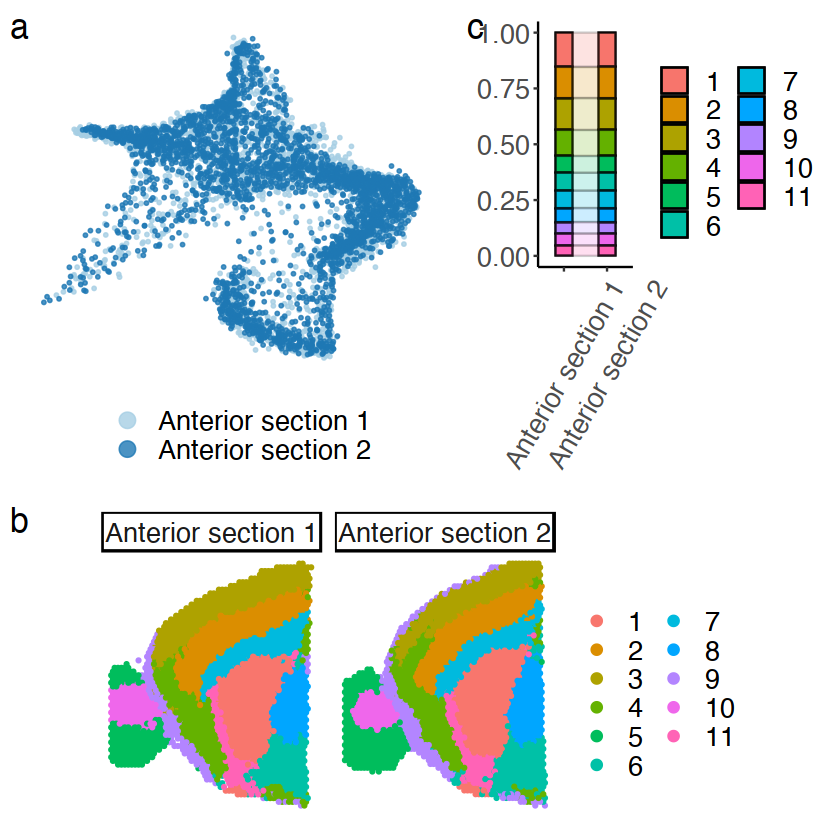

In [1]:
rm(list=ls())
library(rhdf5)
library(ggplot2)
library(ggalluvial)
library(cowplot)
library(RColorBrewer)
library(pheatmap)

batch <- h5read("anterior_section1.h5_anterior_section2.h5_union_ant.h5", "batch")
batch2 <- apply(batch, 2, function(z) which.max(z))
batch3 <- batch2
batch3[batch2==1] <- "Anterior section 1"
batch3[batch2==2] <- "Anterior section 2"

latent <- read.table("final_latent.txt", sep=",")

pos <- t(h5read("anterior_section1.h5_anterior_section2.h5_union_ant.h5", "pos"))
label <- as.numeric(readLines("louvain_clustering_labels.txt"))+1

                
### plot embedding
embed.dat <- data.frame(latent, batch=batch3)

# brewer.pal(4, "Set3")

p1 <- ggplot(embed.dat, aes(x=V1, y=V2, color=batch)) + 
  geom_point(size=0.6, alpha=0.8) + theme_classic() +
  scale_color_brewer(palette = "Paired") +
  guides(colour = guide_legend(override.aes = list(size=4), nrow=2)) +
  theme(axis.title=element_blank(), axis.line=element_blank(), axis.ticks=element_blank(), axis.text=element_blank(),
        legend.position="bottom", legend.title=element_blank(), text = element_text(size=20))

### plot clustering results
cluster.dat <- data.frame(pos, label=label, batch=batch3)

cluster.dat$label <- factor(cluster.dat$label, levels=1:max(label))
cluster.dat$batch <- factor(cluster.dat$batch, levels=c("Anterior section 1", "Anterior section 2"))

p2 <- ggplot(cluster.dat, aes(x=X1, y=X2, color=label)) + 
  facet_wrap(~batch, scales="free") + geom_point(size=0.7) + scale_x_reverse() + coord_flip() +
  theme_classic() + guides(colour = guide_legend(override.aes = list(size=2.5), ncol=2)) +
  theme(axis.title=element_blank(), axis.line=element_blank(), axis.ticks=element_blank(), axis.text=element_blank(),
        legend.title=element_blank(), legend.position = "right", text = element_text(size=20))


### alluvial plot
celltype.dat <- data.frame(celltype=label, batch=batch3)

ante.sec1.celltype.dat <- celltype.dat[celltype.dat$batch=="Anterior section 1",]
ante.sec1.cell_types_prop <- data.frame(prop=table(ante.sec1.celltype.dat$celltype)/length(ante.sec1.celltype.dat$celltype))
ante.sec1.cell_types_prop$Label <- paste(round(ante.sec1.cell_types_prop$prop.Freq * 100, 1), "%", sep="")
ante.sec1.cell_types_prop$prop.Var1 <- factor(ante.sec1.cell_types_prop$prop.Var1, levels=1:max(label))
ante.sec1.cell_types_prop$batch <- "Anterior section 1"


ante.sec2.celltype.dat <- celltype.dat[celltype.dat$batch=="Anterior section 1",]
ante.sec2.cell_types_prop <- data.frame(prop=table(ante.sec2.celltype.dat$celltype)/length(ante.sec2.celltype.dat$celltype))
ante.sec2.cell_types_prop$Label <- paste(round(ante.sec2.cell_types_prop$prop.Freq * 100, 1), "%", sep="")
ante.sec2.cell_types_prop$prop.Var1 <- factor(ante.sec2.cell_types_prop$prop.Var1, levels=1:max(label))
ante.sec2.cell_types_prop$batch <- "Anterior section 2"

cell_types_prop <- rbind(ante.sec1.cell_types_prop, ante.sec2.cell_types_prop)
cell_types_prop$batch <- factor(cell_types_prop$batch, levels=c("Anterior section 1", "Anterior section 2"))

p3 <- ggplot(cell_types_prop, aes(x = batch, y = prop.Freq, fill = prop.Var1, stratum = prop.Var1, alluvium = prop.Var1)) +
  geom_col(width=0.4, color="black") + geom_alluvium(width=0.4, alpha=0.2, color="black") +
  ylab("Fraction") + guides(fill = guide_legend(ncol=2)) + theme_classic() + 
  theme(axis.text.x = element_text(angle = 60, vjust = 0.5, hjust=0.5), axis.title=element_blank(), 
        legend.title = element_blank(), text = element_text(size=20))

plot_grid(plot_grid(p1, p3, align="none", nrow=1, scale=0.95, labels=c("a", "c"), rel_widths=c(1.2, 1), label_size=20),
          plot_grid(NULL,p2,NULL, nrow=1, rel_widths=c(0.1, 1, 0.1)), 
          nrow=2, scale=c(1, 0.95), labels=c("", "b"), rel_heights=c(1, 0.7), label_size=20)


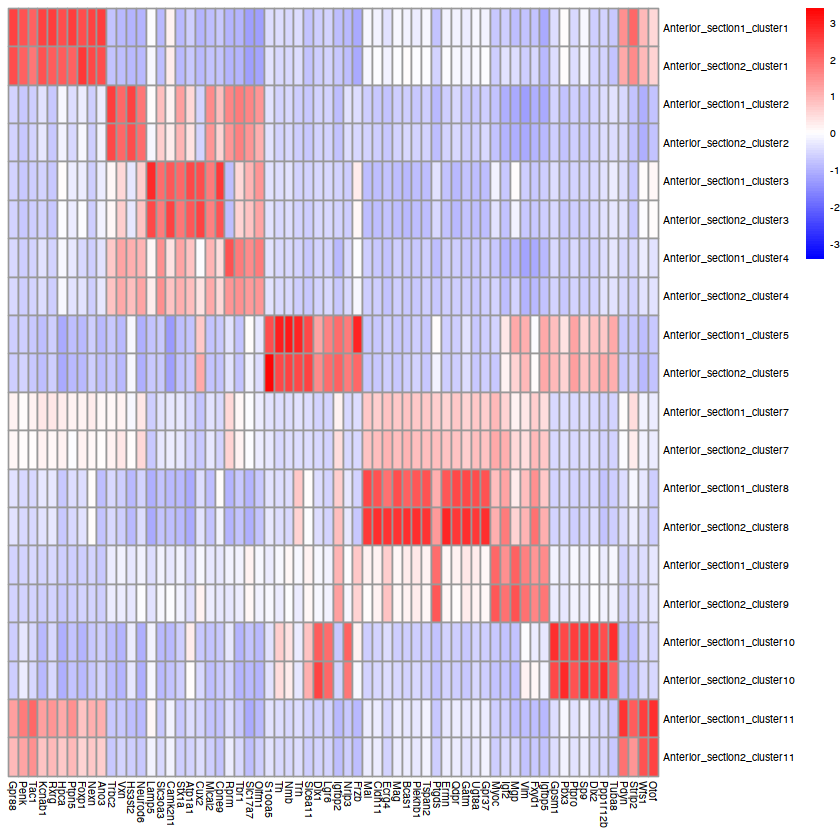

In [2]:
library(pheatmap)

de.res1 = list()
de.res2 = list()
top.genes <- c()
clusters <- c()
j <- 1
for(i in 1:11) {
  if(file.exists(paste("Mouse_anterior_cluster_",i-1,"_vs_others_batch_0_LFC.txt",sep=""))) {
    res1 <- read.table(paste("Mouse_anterior_cluster_",i-1,"_vs_others_batch_0_LFC.txt",sep=""), sep=",", header=T, row.names = 1)
    res1 <- res1[order(res1$LFC, decreasing=T),]
    de.res1[[j]] <- res1
    
    res2 <- read.table(paste("Mouse_anterior_cluster_",i-1,"_vs_others_batch_1_LFC.txt",sep=""), sep=",", header=T, row.names = 1)
    res2 <- res2[order(res2$LFC, decreasing=T),]
    de.res2[[j]] <- res2
    
    res1 <- res1[res1$LFC > 1, ]
    res2 <- res1[res2$LFC > 1, ]
    if(nrow(res1)==0 | nrow(res2)==0) next
    num <- min(nrow(res1), nrow(res2), 10)
    
    clusters <- c(clusters, i)
    j <- j+1
    
    top.g <- intersect(rownames(res1[1:num, ]), rownames(res2[1:num, ]))
    top.genes <- c(top.genes, top.g)
  }
}
top.genes2 <- unique(top.genes)

de.res.top1 <- sapply(de.res1, function(z) {z[top.genes2, "denoised_mean1"]})
rownames(de.res.top1) <- top.genes2
colnames(de.res.top1) <- paste("Anterior_section1_cluster", clusters, sep="")

de.res.top2 <- sapply(de.res2, function(z) {z[top.genes2, "denoised_mean1"]})
rownames(de.res.top2) <- top.genes2
colnames(de.res.top2) <- paste("Anterior_section2_cluster", clusters, sep="")

de.res.top <- cbind(de.res.top1, de.res.top2)
de.res.top <- de.res.top[, paste("Anterior_section", rep(c(1,2), times=length(clusters)), "_cluster", rep(clusters, each=2), sep="")]

de.res.top <- t(scale(t(de.res.top)))
anterior.data.scale <- max(abs(max(de.res.top)), abs(min(de.res.top)))

pheatmap(t(de.res.top), cluster_rows = F, cluster_cols = F, fontsize=6,
              breaks=seq(from=-anterior.data.scale,to=anterior.data.scale,len=100),
              color=colorRampPalette(c("blue", "white", "red"))(100))